### Clustering with Allan test and subtypes

In [19]:
import pandas as pd
import numpy as np
import operator
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN


In [78]:
# Data and features 
df = pd.read_csv("../data/countabilityAnalysis_Celex.csv")
test = ['A+N', 'F+N', 'O-Den']
useless_subtypes = ['Non-Denumerators','approximative', 'comparative', 'round numbers','plural numeral','the'
                    'non denumerating quantifier','partitive', 'measure','digits', 'all+N']
useful_subtypes = [ 'non quantificational', 'precise quantifier','imprecise quantifier',
                  'a/an', 'number']
bares = ['Bare Plural', 'Bare Singular']
npp = ['Plural Noun Percentage']
countability = ['Celex_Countable', 'Celex_Uncountable']


In [46]:
df.columns

Index(['Noun', 'A+N', 'F+N', 'all+N', 'O-Den', 'Bare Singular', 'Bare Plural',
       'Non-Denumerators', 'a/an', 'number', 'digits', 'plural numeral',
       'approximative', 'comparative', 'round numbers', 'imprecise quantifier',
       'precise quantifier', 'non denumerating quantifier', 'measure',
       'non quantificational', 'partitive', 'the', 'N/A', 'Celex_Countable',
       'Celex_Uncountable', 'Noun Count', 'Plural Noun Percentage'],
      dtype='object')

In [93]:
# Clustering features 
cols = test + ['all+N'] + bares
data = df.loc[df['Noun Count']>500, cols+['Noun']]
nouns = data[['Noun']]
data = data.drop(columns=['Noun'])
print(data.columns)
print(data.shape)
ref = data.copy()
ref['Noun'] = nouns
ref_mean = ref.mean(axis=0)

Index(['A+N', 'F+N', 'O-Den', 'all+N', 'Bare Plural', 'Bare Singular'], dtype='object')
(6872, 6)


In [81]:
ref_mean

A+N              0.275828
F+N              0.015626
O-Den            0.071751
all+N            0.004371
Bare Plural      0.128061
Bare Singular    0.300038
dtype: float64

In [94]:
# standard scalar (z-score normalization)
stdscalar = StandardScaler().fit(data)
d2 = stdscalar.transform(data)


In [8]:
# Clustering helpers
def analyse_result(res, labels):
    unique, counts = np.unique(res, return_counts = True)
    uni = dict(zip(unique, counts))
    max = 0
    total = 0
    for key in uni:
        if key == -1 : continue
        val = uni[key]
        if(val > max): max = val
        total += val
    sorted_uni = sorted(uni.items(), key=operator.itemgetter(1))
    print("Clusters found: " + str(res.max()+1))
    noise = np.count_nonzero(res == -1)
    noise2 = round(noise/len(res), 3)*100
    print("Noise: " + str(noise) + " (" + str(noise2) + "%)")
    print("Avarage cluster size: " + str(round(total/len(uni), 3)) + "\nLargest cluster: " + str(max))
    
    return Clustering(res, labels)

class Clustering:
    def __init__(self, res, labels):
        self.clusters = {}
        labels['cluster'] = res
        groups = labels.groupby('cluster')
        for c in range(res.max()+1):
            self.clusters[c] = groups.get_group(c)['Noun'].values
        try:
            self.noise = groups.get_group(-1)['Noun'].values
        except KeyError:
            self.noise = 0
    
    def __str__(self):
        print("---------------------")
        for key in self.clusters:
            print("Cluster: " + str(key) )
            print("Size: " + str(len(self.clusters[key])))
            s = get_similarity(self.clusters[key])
            print(s)
            print("---------------------")
            for w in self.clusters[key]: print(w)
            print(("---------------------"))
        return "end"
    
    def cluster_details(self):
        for key in self.clusters:
            print("Cluster: " + str(key) )
            print("Size: " + str(len(self.clusters[key])))
            s = get_similarity(self.clusters[key])
            print(s)
            print("---------------------")
            
    def print_cluster(self, c):
        print(get_similarity(self.clusters[c]))
        print("---------------------")
        for w in self.clusters[c]:
            print(w)

def get_similarity(cluster):
    df_slice = ref.loc[ref['Noun'].isin(cluster), ref.columns]
    std = df_slice.std(axis=0)
    mean = df_slice.mean(axis=0)
    delta_mean = []
    for col in mean.index:
        delta_mean.append(mean[col]-ref_mean[col])
    
    delta_mean = pd.Series(delta_mean, index=mean.index)
    res = pd.concat([std, mean, delta_mean], axis =1)
    res.columns = ['STD', 'Mean', 'delta Mean']
    return res

In [142]:
def find_words(words, c):
    found = {}
    for k in c.clusters:
        for w in words:
            if w in c.clusters[k]:
                if k in found: found[k].append(w)
                else: found[k] = [w]
    for k, val in found.items():
        for w in val: print(w + "-> " + str(k))
        print("")

def feature_heatmap(clustering, drop, save= False):
    cols = get_similarity(clustering.clusters[0]).index.to_list()
    map_data = pd.DataFrame(columns=['cluster', 'name']+cols)
    
    names = {18:"Denumerable Pluralia Tantum", 22:"Non-denumerable Pluralia Tantum",
             5:"Gregarious Entities/People", 17:"Canonically Plural Nouns (Paired Entities)",
             7:"Core Countable Nouns", 8:"Core Countable Nouns", 9:"Strong Singletons",
             15:"Weakly Denumerable Pluralia Tantum", 1:"Countable/Bare Singular",
             6:"Mainly Singletons/Some Non-countable", 3:"Strongly Non-Countable",
             12:"Core Non-Countable (Denumerable)", 4:"Non-Countable/Singleton Instances",
             0:"Core Non-Countable", 2:"Core Non-Countable" }
    
    count = 0
    for k, c in clustering.clusters.items():
        sim = get_similarity(c)
        map_data.at[count, 'cluster'] = "cluster " + str(k)
        map_data.at[count, 'name'] = names.get(count, "N/A")
        for c in cols:
            map_data.at[count, c] = sim.loc[c, "Mean"]
            
        count += 1
    
#     print(map_data)
    map_data = map_data.drop(columns=['all+N'])
    
    map_data = map_data.drop(map_data.index[drop])
    y_lables = map_data['name'].values
    map_data = map_data.drop(columns=['cluster', 'name'])
    map_data = map_data[map_data.columns].astype(float)
#     map_data = map_data.sort_values(by=['Bare Singular'], ascending=False)
    
    sns.set(font_scale=1.2)
    ax = sns.clustermap(map_data, yticklabels=y_lables, cmap="Greys", metric="canberra",
                        figsize=(8,6), linewidths=1)
    
#     print(ax.dendrogram_col.linkage)
    if save:
        ax.savefig("grey_cluster_heatmap.pdf", bbox_inches="tight")
        print("Figure saved.")
    
    return ax


In [88]:
# DBSCAN clustering
print("---DBSCAN---")
db = DBSCAN(eps=0.9, min_samples=8, metric='canberra').fit(d2)
c2 = analyse_result(db.labels_, nouns)

---DBSCAN---
Clusters found: 23
Noise: 2323 (33.900000000000006%)
Avarage cluster size: 189.042
Largest cluster: 663


In [89]:
words = ['cattle', 'scissors', 'mankind', 'oak', 'equipment', 'banjo', 'spider', 'admiration', 'lamb', 'brick',
        'car', 'beetle', 'bed', 'wine', 'hair', 'material', 'thunder', 'heat', 'wheat', 'physics', 
        'mathamatics', 'lightning', 'evidence', 'water', 'furniture', 'pants', 'measles']
find_words(words, c2)

bed-> 0
heat-> 0
physics-> 0
lightning-> 0
water-> 0

scissors-> 1

equipment-> 2
thunder-> 2
evidence-> 2
furniture-> 2

wheat-> 3

lamb-> 4

spider-> 8

admiration-> 10

pants-> 15

cattle-> 18



Figure saved.


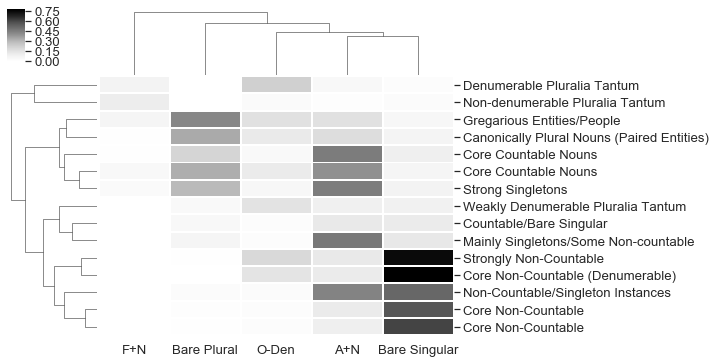

In [143]:
cluster_grid = feature_heatmap(c2, drop=[21,10,14,16,19,11,13,20], save=True)

In [132]:
print(cluster_grid.dendrogram_col.linkage)

[[ 0.          4.          7.18940354  2.        ]
 [ 2.          5.          8.03633195  3.        ]
 [ 3.          6.          9.57594918  4.        ]
 [ 1.          7.         11.62123498  5.        ]]


In [92]:
c2.print_cluster(18)

                    STD      Mean  delta Mean
A+N            0.059277  0.043262   -0.232567
F+N            0.053488  0.076858    0.061232
O-Den          0.161283  0.226494    0.154743
all+N          0.000030  0.000010   -0.004362
Bare Plural    0.018664  0.005788   -0.122273
Bare Singular  0.035890  0.021273   -0.278765
---------------------
books
briefs
cattle
clothes
eleven
foot
fries
goods
manners
mathematics
memoirs
papers
people
percent
personnel
pound
predecessor
prospects
riches
rights
seconds
shades
singles
species
spectacles
statistics
supplies
teens
travels
troops
wares
whites
writings
